# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects on top of existing visibility data, the package also has the `visibilities` module that offers a uniform visibility simulation interface to wrappers for several visibility simulators, as well as a few analytic beam models of the HERA antenna.

## Visibility Simulation Interface

Starting from versions of `hera_sim >= 2.0.0`, wrappers for [VisCPU](https://github.com/HERA-Team/vis_cpu), [healvis](https://github.com/rasg-affiliates/healvis), and [pyuvsim](https://github.com/RadioAstronomySoftwareGroup/pyuvsim) visibility simulators are provided through the `VisCPU`, `Healvis`, and `UVSim` classes.

The new `ModelData` object serves as a container for the visiblity data and all information required to perform visibility simulation. A preferred method to initialize this object is to use the classmethod `from_config`, providing [pyuvsim configuration files](https://pyuvsim.readthedocs.io/en/latest/parameter_files.html) that specify the observation and telescope parameters, beam model, and sky model. Direct initialization is also supported and currently required to utilize analytic HERA beam models in the `hera_sim.beams` module (see [Manual Initialization](###-Manual-Initialization)). Under the hood, ModelData wraps three objects used for facilitating simulation in pyuvsim, each encapsulating different information required for simulating visibility.
* `pyuvdata.UVData`
    * A data container for observation parameters, array layout, telescope location, and visibility.
    * Accesible from the `uvdata` property.
    * Package reference: https://pyuvdata.readthedocs.io/en/latest/index.html
* `pyradiosky.SkyModel`
    * A data container for sky models, including catalog of sources and diffuse sky maps in HEALPix.
    * Provide methods for conversion from a catalog of point sources to a HEALPix map and vice versa, which is used by the visibility simulator wrappers.
    * Accesible from the `sky_model` property.
    * Package reference: https://pyradiosky.readthedocs.io/en/latest/index.html
* `pyuvsim.BeamList` and the associated `beam_ids`
    * Specify the antenna beam models and which beam model each antenna uses. (See [Manual Initialization](###-Manual-Initialization) for supported beam types.)
    * Accesible from the `beams` and `beam_ids` properties.
    * Reference: https://pyuvsim.readthedocs.io/en/latest/classes.html#pyuvsim.BeamList

The `VisibilitySimulation` class is the new uniform visibility simulation interface. It takes an instance of a `VisibilitySimulator` class (of which `VisCPU`, `HealVis` and `UVSim` are examples) and a `ModelData` object as inputs. Visibility simulation can then be executed simply by calling the `simulate` method on an instance of a `VisibilitySimulation` class. This returns a Numpy array of visibilities in the same shape as in the `UVData.data_array` specification, which is also added to the object property `VisibilitySimulation.data_model.uvdata.data_array`.

The motivation behind the `VisibilitySimulation`-`VisibilitySimulator`-`ModelData` setup is to provide a single uniform interface to many simulators, and the ability to create wrappers for simulators that are not already provided. This interface is heavily based on the pyuvsim configuration specifications and infrastructures, and thus it provides the ability to perform simulation with any simulator given the same static configuration.

#### Example 1: Demonstrate the Uniform Visibility Simulator Interface

In [1]:
"""This example simulates visiblities with VisCPU at 10 frequencies and 60 
times with the 50 brightest GLEAM sources as a sky model and the HERA Phase I 
array as the instrument."""
from hera_sim import DATA_PATH
from hera_sim.visibilities import VisCPU, ModelData, VisibilitySimulation


# Path to the example pyuvsim configuration files.
# These can be found in `hera_sim.DATA_PATH` to follow along.
config_file = (
    DATA_PATH / 
    'tutorials_data/visibility_simulator/obsparam_hera_phase1_gleam_top50.yaml'
).as_posix()

# Initialize a ModelData object.
# The pyuvsim configuration files consist of a few yaml and csv files, and a 
# sky model file readable by `pyradiosky`. `ModelData.from_config` takes the 
# outermost file obsparam_*.yaml as an input.
data_model = ModelData.from_config(config_file)

# Initialize a VisCPU simulator.
simulator = VisCPU()
# simulator = VisCPU(use_pixel_beams=False)
# simulator = UVSim(quiet=True)

# Construct a VisibilitySimulation object.
simulation = VisibilitySimulation(data_model=data_model, simulator=simulator)

# Executing the simulation by calling `simulate` method.
visibility_array = simulation.simulate()

## Accessing Simulation Parameters and Visibility

All simulation parameters and visibility data are contained in the `ModelData` object and can be retrieved from the corresponding object attributes and properties.

#### Example 2: Plot the array layout of the simulation in Example 1

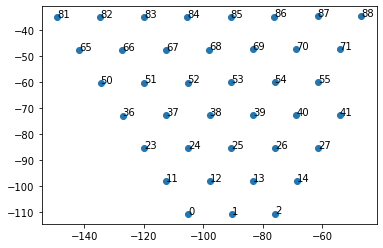

In [2]:
import matplotlib.pyplot as plt
from pyuvdata import utils as uvutils

uvd = simulation.data_model.uvdata

# Get antennas positions and corresponding antenna numbers
antpos, antnum = uvd.get_ENU_antpos()

# Plot the EN antenna position.
plt.scatter(antpos[:, 0], antpos[:, 1])
for i, antnum in enumerate(uvd.antenna_numbers):
    plt.text(antpos[i, 0], antpos[i, 1], antnum)
plt.show()

#### Example 3: Plot the source positions in the SkyModel used in Example 1 

Type of sky model: point
Number of sources: 50


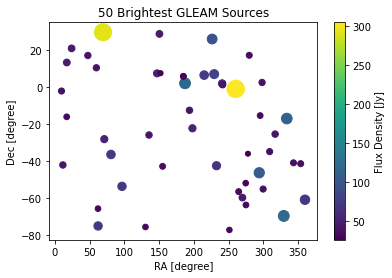

In [3]:
sky_model = simulation.data_model.sky_model
print('Type of sky model:', sky_model.component_type)
print('Number of sources:', sky_model.Ncomponents)

# Extract the source positions and fluxes
ra = sky_model.ra
dec = sky_model.dec
flux = sky_model.stokes[0, 0, :]

# Plot the source positions with color and size showing source fluxes.
plt.scatter(ra, dec, s=flux, c=flux)
plt.colorbar(label='Flux Density [Jy]')
plt.xlabel('RA [degree]')
plt.ylabel('Dec [degree]')
plt.title('50 Brightest GLEAM Sources')
plt.show()

#### Example 4: Plot the waterfall of the visibility simulation in Example 1

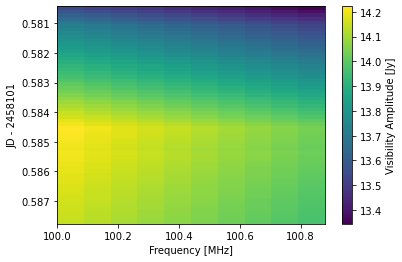

In [4]:
import numpy as np

bls = (0, 1, 'xx')
waterfall = uvd.get_data(bls)
extent = [uvd.freq_array[0, 0] / 1e6, uvd.freq_array[0, -1] / 1e6, 
          uvd.time_array[-1] - 2458101, uvd.time_array[0] - 2458101]
plt.imshow(np.abs(waterfall), aspect='auto', interpolation='none', 
           extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('JD - 2458101')
plt.colorbar(label=f'Visibility Amplitude [{uvd.vis_units}]')
plt.show()

For more comprehensive visualization of visibility data (e.g. waterfalls of differences between visibilities, Fourier Transform of a waterfall, and etc), users may be interested in plotting routines in the HERA [uvtools](https://github.com/HERA-Team/uvtools) package.

## Initializing Model Data

As mentioned, the `ModelData` object contains all the data and information required to perform visibility simulation with `hera_sim`.

The prefered method to initlize a ModelData object is to generate a set pyuvsim configuration files (see https://pyuvsim.readthedocs.io/en/latest/parameter_files.html) and then pass the top-level <em>obsparams_*.yaml</em> file to the classmethod `from_config`.

```python
data_model = ModelData.from_config(config_file)
```

### Manual Initialization

If not using configuration files, the underlying objects can be first created and passed to the `ModelData` constructor for manual initialization. 

Users may consider using `hera_sim.io.empty_uvdata`, `pyuvsim.simsetup.initialize_uvdata_from_params`, or `pyuvsim.simsetup.initialize_uvdata_from_keywords` to construct a UVData object. 

See the next section on how to construct a sky model with `pyradiosky.SkyModel`.

The beam models given to the `beams` parameter can be: i) a `pyuvsim.BeamList` object, ii) a `pyuvdata.UVBeam`, or iii) a list of `pyuvsim.AnalyticBeam`, including its subclasses.

The `hera_sim.beams` module provides analytic models of the HERA antenna through the `PolyBeam`, `PerturbedPolayBeam`, and `ZernikeBeam`  objects (see HERA Memo [#081](http://reionization.org/wp-content/uploads/2013/03/HERA081_HERA_Primary_Beam_Chebyshev_Apr2020.pdf) and [#101](http://reionization.org/manual_uploads/HERA101_Analytic_polarized_beam.pdf), and [Choudhuri et al 2021](https://arxiv.org/abs/2101.02684)). Although these beam models are subclasses of `pyuvsim.AnalyticBeam`, they are currently not regcogniziable by the pyuvsim configuration file parser, and thus can only be used by initializing `ModelData` manually.

#### Example 5: Manaully initialize a `ModelData` object with `PolyBeam`

In [5]:
from pyuvsim.simsetup import initialize_uvdata_from_params, _complete_uvdata
from pyuvsim import BeamList
from pyradiosky import SkyModel
from hera_sim.beams import PolyBeam

# Initialize just the UVData and beam_ids from the pyuvsim configuraton files.
# The configuration file (same as in Example 1) uses the "airy" type 
# `pyuvsim.AnalyticBeam` as the beam models. Here, 
# `pyuvsim.simsetup.initialize_uvdata_from_param` returns `UVData`, `BeamList`, 
# and `beam_ids`, but we will discard and replace the `BeamList` with a new 
# `BeamList` that uses the `PolyBeam` model.
uvdata, _, beam_ids = initialize_uvdata_from_params(config_file)
# Fill `data_array` with zeros and commplete the UVData object.
_complete_uvdata(uvdata, inplace=True)

# Construct a new `BeamList` with polarized `PolyBeam`.
# `beam_coeffs` from Choudhuri et al 2020. 
cfg_pol_beam = dict(
    ref_freq=1e8,
    spectral_index=-0.6975,
    beam_coeffs=[
        2.35088101e-01,
        -4.20162599e-01,
        2.99189140e-01,
        -1.54189057e-01,
        3.38651457e-02,
        3.46936067e-02,
        -4.98838130e-02,
        3.23054464e-02,
        -7.56006552e-03,
        -7.24620596e-03,
        7.99563166e-03,
        -2.78125602e-03,
        -8.19945835e-04,
        1.13791191e-03,
        -1.24301372e-04,
        -3.74808752e-04,
        1.93997376e-04,
        -1.72012040e-05,
    ],
    polarized=True,
)
beams = BeamList([PolyBeam(**cfg_pol_beam)])

# Load the SkyModel. Same model used in Example 1.
sky_model_file = (
    DATA_PATH /
    'tutorials_data/visibility_simulator/gleam_top50.skyh5'
).as_posix()
sky_model = SkyModel()
sky_model.read_skyh5(sky_model_file)

# Construct ModelData
data_model_polybeam = ModelData(
    uvdata=uvdata,
    sky_model=sky_model,
    beam_ids=beam_ids,
    beams = beams               
)

### Constructing a SkyModel

`pyradiosky.SkyModel` is both a container and an interface for representing astrophysical radio sources. 

A `SkyModel` object will usually consist of many components that represent either compact point sources or pixels of a HEALPix map. This choice can be set by specifying `component_type="point"` or `component_type="healpix"` when constructing the object. Doing so will determine which parameters are required as followed.
* If `component_type="point"`, the `name` of each source and the source position (`ra` and `dec`) are required.
* If `component_type="healpix"`, the `nside` parameter of the HEALPix map, the indices of the HEALPix pixel `hpx_inds`, and the HEALPix pixel ordering `hpx_order` must be set. 
* If `component_type` is not set, the type is infered from weather `nside` is given.

The component flux is given per frequency as an array of Stoke IQUV via the `stokes` argument (Shape: (4, Nfreqs, Ncomponents)). In addition, the `spectral_type` must be specified, which can be:
* "flat" : Flat spectrum.
* "full" : Flux is defined at each frequency given in the `freq_array` attribute.
* "subband" : Flux is defined at a set of band centers give in the `freq_array` attribute.
* "spectral_index" : Flux is defined at a reference frequency set in the `reference_frequency` attribute and follows a power law given a spectral index set in the `spectral_index` attribute.

The method `at_frequencies` can be used to evaluate the stokes array of a SkyModel object at specified frequencies, converting the object to a "full" spectral type when `inplace=True`, or yielding a new instance of the object with a "full" spectral type if `inplace=False`.

The classmethods `pyradiosky.from_gleam_catalog`, `pyradiosky.from_votable_catalog`, and `pyradiosky.from_text_catalog` can be used to `SkyModel` object from the GLEAM EGC catalog file, a votable catalog file, or from a tab separated value file. The `pyuvsim.simsetup.create_mock_catalog` method can also be used to create a mock catalog of point source and/or diffuse sky

Loading a HEALPix map into a SkyModel object is currently only possible via the native skyh5 file format. Thus, a diffuse sky map in a HEALPix FITS format (e.g., Haslam 408 MHz) must be manually initialized from the HEALPix array values and indices.

A method for converting a `SkyModel` object from one component type to another is provided, which can be used to convert a  "healpix" model to "point" and combine with another "point"-type model, for example. This conversion is used by `hera_sim` in its VisCPU and healvis wrappers.

Below, we show how to create a random point source model and a uniformly distrubuted diffuse model, and combine them into a single SkyModel object. Please refer to the [pyradiosky developer API](https://pyradiosky.readthedocs.io/en/latest/index.html) for details of the objects parameters and methods.

#### Example 6: Construct a random point source SkyModel

In [6]:
from pyradiosky import SkyModel
from astropy.coordinates import Longitude, Latitude
from astropy import units as u

## Point Soruce Model ##
component_type = 'point'

# Each source is a component in a SkyModel.
# Create a sky model with 50 random sources (i.e. 50 point source components).
nsources = 100

# `ra` and `dec` must be Longitude and Latitude astropy quantity
ra = Longitude(np.random.uniform(0, 360, nsources) * u.degree)
dec = Latitude(np.random.uniform(-90, 90, nsources) * u.degree)

# `names` are required for point soruces
names = [f'rand{i:02d}' for i in range(nsources)]

# SkyModel supports several spectral type. We will use "spectral_index" here,
# where the flux of each source is describe by a power law given a reference 
# frequency and a spectral index.
spectral_type = 'spectral_index'
spectral_index = np.random.uniform(-4, 3, nsources)
reference_frequency = 200e6 * np.ones(nsources) * u.Hz

# Source fluxes must be given in Stokes IQUV as an array of astropy quantity 
# with an appropriate unit. Shape (4, Nfreqs, Ncomponents).
# Nfreqs is 1 here because we are using "spctral_index".
stokes = np.zeros((4, 1, nsources)) * u.Jy
stokes[0, :, :] = np.random.uniform(10, 100, nsources) * u.Jy
# Let's also give our sources ~10% linar polarization
stokes[1, :, :] = np.random.uniform(1, 5, nsources) * u.Jy
stokes[2, :, :] = np.random.uniform(1, 5, nsources) * u.Jy

# Collect all parameters in a dictionary to be passed to a SkyModel constructor
source_params = {
    'component_type': component_type,
    'name': names,
    'ra': ra,
    'dec': dec,
    'stokes': stokes,
    'spectral_type': spectral_type,
    'reference_frequency': reference_frequency,
    'spectral_index': spectral_index,
    'history': ' Generate a random polarized source catalog with 50 sources.\n'
}

source_model = SkyModel(**source_params)

print('SkyModel History:\n', source_model.history)
print('Type of sky model:', source_model.component_type)
print('Number of components = number of sources:', source_model.Ncomponents)

SkyModel History:
  Generate a random polarized source catalog with 50 sources.
  Read/written with pyradiosky version: 0.1.2.
Type of sky model: point
Number of components = number of sources: 100


#### Example 7: Construct a uniformly distributed diffuse HEALPix SkyModel

In [7]:
# Create a diffuse HEALPix SkyModel with a "rainbow" sky and flat spectra.
component_type = 'healpix'
nside = 2 ** 3
npix = 12 * nside ** 2
hpx_order = 'ring'
hpx_inds = np.arange(npix)

spectral_type = 'flat'

stokes = np.zeros((4, 1, npix)) * u.K
stokes[0, :, :] = np.random.uniform(400, 500, npix) * u.K

diffuse_params = {
    'component_type': component_type,
    'nside': nside,
    'hpx_inds': hpx_inds,
    'hpx_order': hpx_order,
    'spectral_type' : spectral_type,
    'stokes': stokes,
    'history': ' Create a diffuse "rainbow" sky with a flat spectra.\n'
}
diffuse_model = SkyModel(**diffuse_params)
print('SkyModel History:\n', diffuse_model.history)
print('Type of sky model:', diffuse_model.component_type)
print('Nside:', diffuse_model.nside)
print('Number of components = number of healpix pixels:', 
      diffuse_model.Ncomponents)

SkyModel History:
  Create a diffuse "rainbow" sky with a flat spectra.
  Read/written with pyradiosky version: 0.1.2.
Type of sky model: healpix
Nside: 8
Number of components = number of healpix pixels: 768


#### Example 8: Convert one SkyModel type to another and concatnate two SkyModel objects

One model type can be converted to another type and concatenated to form a composite model. The concatnation can only be done if `component_type`, `spectral_type`, and `freq_array` of both objects matches

In [8]:
# Evaluate both sky models at frequencies in Example 1 simulation before
# concatenating.
frequencies = simulation.data_model.uvdata.freq_array[0] * u.Hz
source_model_full = source_model.at_frequencies(frequencies, inplace=False)
diffuse_model_full = diffuse_model.at_frequencies(frequencies, inplace=False)

# Drop spectral_index from the source model before combining.
# See GitHub issue https://github.com/RadioAstronomySoftwareGroup/pyradiosky/issues/160
source_model_full.spectral_index = None

# Convert the diffuse model to "point" type, making sure the flux unit 
# is also converted to jansky
diffuse_model_full.healpix_to_point(to_jy=True)
composite_model = source_model_full.concat(diffuse_model_full, inplace=False)

Let's run some simulations with these sky models and other speciication the same as in [Example 1](####-Example-1:-Demonstrate-the-Unifrom-Visibility-Simulator-Interface) and compare the output visibilities.

In [9]:
# Define a function to run the simulation.
def run_simulation(sky_model):
    """Create and run a simulation given a sky model."""
    # Use the same config file as in Example 1 to initialize UVdata and beams.
    uvdata, beams, beam_ids = initialize_uvdata_from_params(config_file)
    _complete_uvdata(uvdata, inplace=True)
    
    # Initialize ModelData given the SkyModel
    data_model = ModelData(uvdata=uvdata, sky_model=sky_model, 
                           beams=beams, beam_ids=beam_ids)

    # Initialize a VisibilitySimulation instance, using VisCPU
    simulation = VisibilitySimulation(
        data_model=data_model,
        simulator=VisCPU(use_pixel_beams=True)
    )
    _  = simulation.simulate()
    
    return simulation


source_sim = run_simulation(source_model_full)
diffuse_sim = run_simulation(diffuse_model_full)
composite_sim = run_simulation(composite_model)

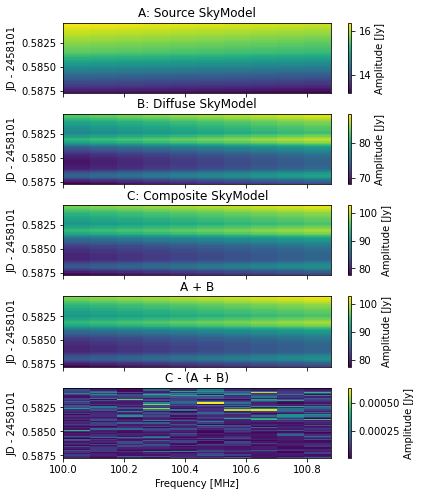

In [10]:
# Define some labels for all the cases that we want to compare
waterfall_labels = ['A: Source SkyModel', 'B: Diffuse SkyModel', 
                    'C: Composite SkyModel',
                    'A + B', 'C - (A + B)']

# Get waterfalls of the complex visibility, 
# same baseline (0, 1, 'xx') as in Example 1.
waterfall_list = [sim.data_model.uvdata.get_data(bls)
                  for sim in [source_sim, diffuse_sim, composite_sim]]

# Make A + B, and C - (A + B), add them to the list
waterfall_list.append(waterfall_list[0] + waterfall_list[1])
waterfall_list.append(waterfall_list[2] - waterfall_list[3])

# Extent for the waterfall plot, same for all three simulations
extent = [source_sim.uvdata.freq_array[0, 0] / 1e6, 
          source_sim.uvdata.freq_array[0, -1] / 1e6, 
          source_sim.uvdata.time_array[-1] - 2458101, 
          source_sim.uvdata.time_array[0] - 2458101]

# Plotting
fig, ax = plt.subplots(5, 1, sharex='all', sharey='all', figsize=(6, 8))
for i, waterfall in enumerate(waterfall_list):
    im = ax[i].imshow(np.abs(waterfall), aspect='auto', interpolation='none', 
                      extent=extent)
    fig.colorbar(im, ax=ax[i], label='Amplitude [Jy]')
    ax[i].set_title(waterfall_labels[i]) 
    ax[i].set_ylabel('JD - 2458101')
ax[-1].set_xlabel('Frequency [MHz]')
fig.subplots_adjust(hspace=0.3)

## Simulator Choices

`hera_sim.visibilities` provide wraper classes for three visibility simulators, allowing them to be used in the new uniform interface. These classes are actually subclasses of the `VisibilitySimulator` class, a new abstract class that serves as a template for wrapping visibility simulators to be used with the uninorm interface, making it easy to create your own wrapper for a different simulator. 

Each of the simulator approaches the visibility calculation differently with its own merits.

### VisCPU
`VisCPU` is the wrapper for the [vis_cpu](https://github.com/HERA-Team/vis_cpu) package, a Python/numpy-based simulator for interferometer visibilities developed by members from HERA collaboration. It models the sky as an ensemble of point sources, each with their own frequency spectrum. The code is capable of modelling polarized visibilities and primary beams, but currently only a Stokes I sky model. 

The [HERA Memo #98](http://reionization.org/manual_uploads/HERA098_vis_cpu_maths.pdf) describes the mathematical underlying of the `vis_cpu` simulator although be warned that some information might have already been obsolete due to the recent rapid development of the simulator. In summary, vis_cpu computes a geometric delay for each source and antenna, which is used to calculate the phase factor that is then multiplied by the source flux to obtain per-antenna visibility factor. The direction-dependent polarized antenna beam factor (Jones matrix) is computed by evaluating the complex (efield) antenna pattern at each source position on the azimutal-zenithal coordinates. This is usually done by calling the `interp` method of the UVBeam object, or by directly evaluating an analytic function in the case of using an analytic beam model. All of these are done per time at a given _single_ frequency. 

The `hera_sim` wrapper is default to used the "pixel beam" mode, which interpolates each anteanna beam once onto an (l, m) grid that is then used to constructs a 2D Bivariate spline. The spline object is evaluated given a source position to estimate the antenna beam pattern. This bypasses the need to compute the new (l, m) coordinates at every time, and, although less accurate, is usually faster for complex efield beams. However, analytic beam models such as the `PolyBeam` object can precisely and quickly give the beam value at any given az-za coordinate. Thus, pixel beam mode should _not_ be used when using analytic beam models.

The `hera_sim` wrapper also adds a frequency loop on top of the internal time loop in vis_cpu codes and interfaces between the `ModelData` to vis_cpu input parameters, including transformation of a HEALPix SkyModel into a point source model. MPI parallelization over frequencies is also implemented on the `hera_sim` wrapper although shared memory is currently not supported.

### HealVis
The `HealVis` class provide a wrapper for the [healvis](https://github.com/rasg-affiliates/healvis) simulator. healvis simulates visibility off of HEALPix shells by directly evaluating the radio interferometry measurement equation (RIME) at the healpix pixels, avoiding artifacts from sky projection (see Section 3. of [Lanman et al. 2020](https://arxiv.org/abs/1910.10573) for the underlying mathematical formalism). Due to this unique calculation, a point source catalog must be gridded onto a healpix map to use in healvis. The `hera_sim` wrapper facilites this conversion through the interface between the `HealVis` wrapper and the `ModelData` object.

### UVSim
The `UVSim` class provides a `hera_sim` wrapper to [pyuvsim](https://pyuvsim.readthedocs.io/en/latest/index.html), a comprehensive simulation package for radio interferometers that emphasizes accuracy and extensibility over speed. Under the hood, it execute `pyuvsim.uvsim.run_uvdata_uvsim` given the information in the `ModelData` object.

### Creating a Custom Simulator

The `VisibilitySimulator` abstract base class defines the required class infrastructure for creating a custom simulator.

In [11]:
from hera_sim.visibilities import VisibilitySimulator

VisibilitySimulator??

Init signature: VisibilitySimulator()
Source:        
class VisibilitySimulator(metaclass=ABCMeta):
    """Base class for all hera_sim compatible visibility simulators."""

    #: Whether this particular simulator has the ability to simulate point
    #: sources directly.
    point_source_ability = True

    #: Whether this particular simulator has the ability to simulate diffuse
    #: maps directly.
    diffuse_ability = False

    __version__ = "unknown"

    @abstractmethod
    def simulate(self, data_model: ModelData) -> np.ndarray:
        """Simulate the visibilities."""
        pass

    def validate(self, data_model: ModelData):
        """Check that the data model complies with the assumptions of the simulator."""
        pass
File:           ~/src/miniconda3/envs/hera_sim_dev/lib/python3.8/site-packages/hera_sim/visibilities/simulators.py
Type:           ABCMeta
Subclasses:     UVSim, VisCPU, HealVis


A custom simulator can be made by subclassing the `VisibilitySimulator` class and overriding the `simulate` method, which must take a `ModelData` object as an input and must return a Numpy array with the same shap as `UVData.data_array`. The `validate` method may be override, and `point_source_ability` and `diffuse_ability`atrributes may be set, as neccessary.

Let's take a look at the codes of the `UVSim` class that wraps the pyuvsim simulator as an example. It defines a `simulate` method that calls `pyuvsim.uvsim.run_uvdata_uvsim`, passing in a UVData object from the ModelData input, and returning the `data_array` from the UVData output.

In [12]:
from hera_sim.visibilities import UVSim

UVSim??

Init signature: UVSim(quiet: bool = False)
Source:        
class UVSim(VisibilitySimulator):
    """A wrapper around the pyuvsim simulator.

    Parameters
    ----------
    quiet
        If True, don't print anything.
    """

    def __init__(self, quiet: bool = False):
        self.quiet = quiet

    def simulate(self, data_model: ModelData):
        """Simulate the visibilities."""
        beam_dict = {
            ant: data_model.beam_ids[str(idx)]
            for idx, ant in enumerate(data_model.uvdata.antenna_names)
        }

        # TODO: this can be removed once
        # https://github.com/RadioAstronomySoftwareGroup/pyuvsim/pull/357
        # is mereged.
        if data_model.sky_model.name is not None:
            data_model.sky_model.name = np.array(data_model.sky_model.name)

        warnings.warn(
            "UVSim requires time-ordered data. Ensuring that order in UVData..."
        )
        data_model.uvdata.reorder_blts("time")

        # The UVData object must 